In [ ]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras import regularizers, Model
from keras.layers import Dense, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
import random
import shutil

from tensorflow.keras.applications.xception import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setup data splits in generators

In [ ]:
target = 299 # number of pixels. change this to 512 if you want to use the full image size. note: will slow computations

dataPath = '/kaggle/input/glaucoma-dataset-eyepacs-airogs-light-v2/eyepac-light-v2-512/'

batchSize = 4

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 4, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 15.0)
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    image = preprocess_input(image)
    return image

# combine two unique generators using noise injection
batchSize = 8
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.9, 1.1))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 770 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


## Create a MobileNetV3 instance

In [ ]:
# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.Xception(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-2))(x)
    x = Dropout(0.5)(x)
    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=1, min_lr=1e-5)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Pre-Optimize Weights

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(trainGen, steps_per_epoch = len(trainGen1)//2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 3.9570 - binary_accuracy: 0.6425 - auc: 0.6950 - precision: 0.6493 - recall: 0.6404

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 151s 235ms/step - loss: 3.9570 - binary_accuracy: 0.6425 - auc: 0.6950 - precision: 0.6493 - recall: 0.6404 - val_loss: 1.5057 - val_binary_accuracy: 0.6649 - val_auc: 0.8158 - val_precision: 0.8713 - val_recall: 0.3870 - lr: 0.0010
Epoch 2/5
500/500 [==============================] - 109s 218ms/step - loss: 0.7166 - binary_accuracy: 0.7843 - auc: 0.8560 - precision: 0.8275 - recall: 0.7146 - val_loss: 0.5923 - val_binary_accuracy: 0.8506 - val_auc: 0.9173 - val_precision: 0.8610 - val_recall: 0.8364 - lr: 0.0010
Epoch 3/5
500/500 [==============================] - 104s 208ms/step - loss: 0.6299 - binary_accuracy: 0.8375 - auc: 0.9064 - precision: 0.8549 - recall: 0.8092 - val_loss: 0.5386 - val_binary_accuracy: 0.8935 - val_auc: 0.9504 - val_precision: 0.8816 - val_recall: 0.9091 - lr: 0.0010
Epoch 4/5
500/500 [==============================] - 99s 198ms/step - loss: 0.5995 - binary_accuracy: 0.8625 - auc: 0.9198 - precision: 0.8831 - recall:

## Train Model

In [ ]:
batchSize = 8
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True,rotation_range=360,brightness_range=(0.9, 1.1))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=10, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/10
2000/2000 [==============================] - 629s 302ms/step - loss: 0.7504 - binary_accuracy: 0.7998 - auc_1: 0.8701 - precision_1: 0.8263 - recall_1: 0.7592 - val_loss: 0.6258 - val_binary_accuracy: 0.8779 - val_auc_1: 0.9410 - val_precision_1: 0.8779 - val_recall_1: 0.8779 - lr: 0.0010
Epoch 2/10
2000/2000 [==============================] - 600s 300ms/step - loss: 0.7377 - binary_accuracy: 0.8319 - auc_1: 0.9010 - precision_1: 0.8491 - recall_1: 0.8073 - val_loss: 0.6679 - val_binary_accuracy: 0.8961 - val_auc_1: 0.9494 - val_precision_1: 0.8920 - val_recall_1: 0.9013 - lr: 0.0010
Epoch 3/10
2000/2000 [==============================] - 597s 299ms/step - loss: 0.6135 - binary_accuracy: 0.8606 - auc_1: 0.9240 - precision_1: 0.8672 - recall_1: 0.8515 - val_loss: 0.4891 - val_binary_accuracy: 0.9026 - val_auc_1: 0.9651 - val_precision_1: 0.8799 - val_recall_1: 0.9325 - lr: 8.5000e-04
Epoch 4/10
2000/2000 [==============================] - 598s 299ms/step - loss: 0.5869 - bina

## Examine the training history

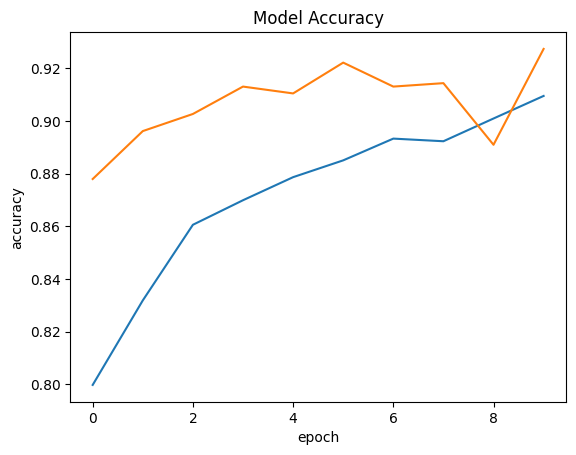

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

## Evaluate results on the test set

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 13s 17ms/step - loss: 0.3313 - binary_accuracy: 0.9299 - auc_1: 0.9760 - precision_1: 0.9233 - recall_1: 0.9377


[0.33134546875953674,
 0.9298701286315918,
 0.9759588837623596,
 0.9232736825942993,
 0.9376623630523682]

## Continue training

In [ ]:
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 596s 298ms/step - loss: 0.3967 - binary_accuracy: 0.9094 - auc_1: 0.9627 - precision_1: 0.9082 - recall_1: 0.9107 - val_loss: 0.3403 - val_binary_accuracy: 0.9234 - val_auc_1: 0.9754 - val_precision_1: 0.9289 - val_recall_1: 0.9169 - lr: 5.2201e-04
Epoch 2/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.3894 - binary_accuracy: 0.9114 - auc_1: 0.9650 - precision_1: 0.9105 - recall_1: 0.9128 - val_loss: 0.4129 - val_binary_accuracy: 0.9143 - val_auc_1: 0.9796 - val_precision_1: 0.8584 - val_recall_1: 0.9922 - lr: 5.2201e-04
Epoch 3/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.3603 - binary_accuracy: 0.9159 - auc_1: 0.9680 - precision_1: 0.9151 - recall_1: 0.9169 - val_loss: 0.3428 - val_binary_accuracy: 0.9260 - val_auc_1: 0.9775 - val_precision_1: 0.9162 - val_recall_1: 0.9377 - lr: 4.4371e-04
Epoch 4/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.3333 - 

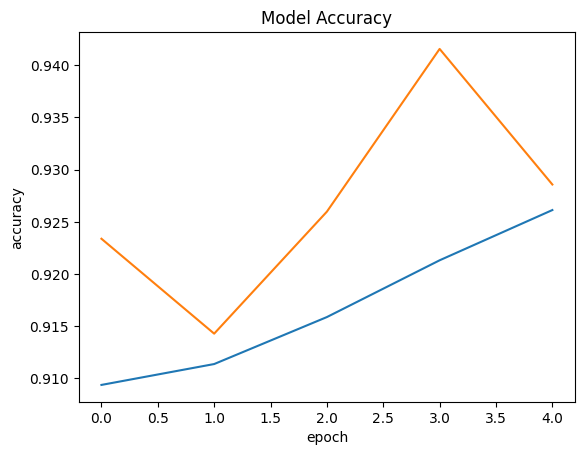

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 9s 11ms/step - loss: 0.2967 - binary_accuracy: 0.9312 - auc_1: 0.9783 - precision_1: 0.9235 - recall_1: 0.9403


[0.29672765731811523,
 0.9311688542366028,
 0.9782965183258057,
 0.9234693646430969,
 0.9402597546577454]

In [ ]:
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 593s 297ms/step - loss: 0.3049 - binary_accuracy: 0.9273 - auc_1: 0.9748 - precision_1: 0.9242 - recall_1: 0.9304 - val_loss: 0.2778 - val_binary_accuracy: 0.9286 - val_auc_1: 0.9814 - val_precision_1: 0.9388 - val_recall_1: 0.9169 - lr: 3.2058e-04
Epoch 2/5
2000/2000 [==============================] - 592s 296ms/step - loss: 0.3038 - binary_accuracy: 0.9263 - auc_1: 0.9750 - precision_1: 0.9235 - recall_1: 0.9300 - val_loss: 0.2681 - val_binary_accuracy: 0.9312 - val_auc_1: 0.9801 - val_precision_1: 0.9346 - val_recall_1: 0.9273 - lr: 3.2058e-04
Epoch 3/5
2000/2000 [==============================] - 591s 296ms/step - loss: 0.3022 - binary_accuracy: 0.9295 - auc_1: 0.9757 - precision_1: 0.9281 - recall_1: 0.9312 - val_loss: 0.3037 - val_binary_accuracy: 0.9390 - val_auc_1: 0.9795 - val_precision_1: 0.9082 - val_recall_1: 0.9766 - lr: 3.2058e-04
Epoch 4/5
2000/2000 [==============================] - 592s 296ms/step - loss: 0.2837 - 

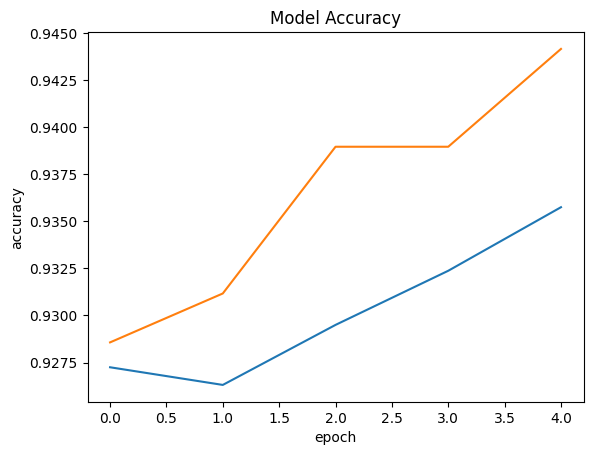

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 9s 11ms/step - loss: 0.2779 - binary_accuracy: 0.9312 - auc_1: 0.9812 - precision_1: 0.8952 - recall_1: 0.9766


[0.2778569757938385,
 0.9311688542366028,
 0.981150209903717,
 0.8952381014823914,
 0.9766233563423157]

In [ ]:
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.2508 - binary_accuracy: 0.9386 - auc_1: 0.9807 - precision_1: 0.9313 - recall_1: 0.9473 - val_loss: 0.2754 - val_binary_accuracy: 0.9286 - val_auc_1: 0.9808 - val_precision_1: 0.8929 - val_recall_1: 0.9740 - lr: 2.3162e-04
Epoch 2/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.2502 - binary_accuracy: 0.9374 - auc_1: 0.9807 - precision_1: 0.9313 - recall_1: 0.9440 - val_loss: 0.2456 - val_binary_accuracy: 0.9403 - val_auc_1: 0.9825 - val_precision_1: 0.9227 - val_recall_1: 0.9610 - lr: 2.3162e-04
Epoch 3/5
2000/2000 [==============================] - 593s 297ms/step - loss: 0.2503 - binary_accuracy: 0.9376 - auc_1: 0.9813 - precision_1: 0.9314 - recall_1: 0.9457 - val_loss: 0.2308 - val_binary_accuracy: 0.9390 - val_auc_1: 0.9823 - val_precision_1: 0.9204 - val_recall_1: 0.9610 - lr: 2.3162e-04
Epoch 4/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.2436 - 

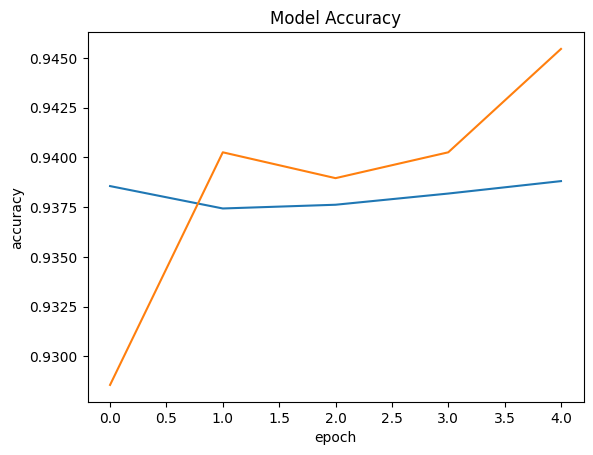

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 9s 11ms/step - loss: 0.2434 - binary_accuracy: 0.9286 - auc_1: 0.9809 - precision_1: 0.9319 - recall_1: 0.9247


[0.24341543018817902,
 0.9285714030265808,
 0.9809243679046631,
 0.9319371581077576,
 0.9246753454208374]

In [ ]:
model.save('trained.h5')

In [ ]:
# model isnt training well anymore, so reduce the dropout rate and resume training
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.Xception(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.35)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-2))(x)
    x = Dropout(0.35)(x)
    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)
model.load_weights('trained.h5')

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])

history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 627s 301ms/step - loss: 0.1926 - binary_accuracy: 0.9459 - auc_2: 0.9863 - precision_2: 0.9404 - recall_2: 0.9520 - val_loss: 0.1863 - val_binary_accuracy: 0.9455 - val_auc_2: 0.9866 - val_precision_2: 0.9320 - val_recall_2: 0.9610 - lr: 1.0000e-04
Epoch 2/5
2000/2000 [==============================] - 593s 297ms/step - loss: 0.1889 - binary_accuracy: 0.9463 - auc_2: 0.9862 - precision_2: 0.9396 - recall_2: 0.9538 - val_loss: 0.1900 - val_binary_accuracy: 0.9442 - val_auc_2: 0.9864 - val_precision_2: 0.9318 - val_recall_2: 0.9584 - lr: 1.0000e-04
Epoch 3/5
2000/2000 [==============================] - 594s 297ms/step - loss: 0.1768 - binary_accuracy: 0.9490 - auc_2: 0.9874 - precision_2: 0.9429 - recall_2: 0.9561 - val_loss: 0.1905 - val_binary_accuracy: 0.9377 - val_auc_2: 0.9854 - val_precision_2: 0.9332 - val_recall_2: 0.9429 - lr: 8.5000e-05
Epoch 4/5
2000/2000 [==============================] - 591s 296ms/step - loss: 0.1758 - 

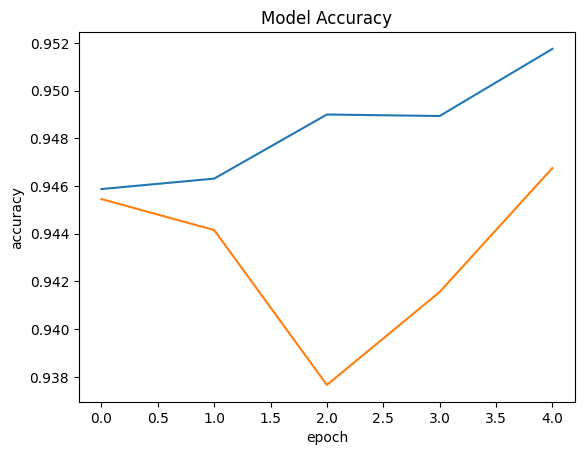

In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 9s 11ms/step - loss: 0.1885 - binary_accuracy: 0.9416 - auc_2: 0.9827 - precision_2: 0.9293 - recall_2: 0.9558


[0.18847912549972534,
 0.9415584206581116,
 0.9826580882072449,
 0.9292929172515869,
 0.9558441638946533]

In [ ]:
# model isnt training well anymore, so reduce the dropout rate and resume training
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    transfer = keras.applications.Xception(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.output
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-2))(x)
    x = Dropout(0.25)(x)
    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
model = getModel(image_size=target, num_classes=1)
model.load_weights('val-best.h5')

In [ ]:
model.compile(optimizer=Adam(5e-5), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=5, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/5
2000/2000 [==============================] - 619s 297ms/step - loss: 0.1652 - binary_accuracy: 0.9501 - auc_3: 0.9877 - precision_3: 0.9441 - recall_3: 0.9566 - val_loss: 0.1689 - val_binary_accuracy: 0.9494 - val_auc_3: 0.9867 - val_precision_3: 0.9369 - val_recall_3: 0.9636 - lr: 5.0000e-05
Epoch 2/5
2000/2000 [==============================] - 591s 296ms/step - loss: 0.1547 - binary_accuracy: 0.9530 - auc_3: 0.9892 - precision_3: 0.9456 - recall_3: 0.9614 - val_loss: 0.1775 - val_binary_accuracy: 0.9494 - val_auc_3: 0.9846 - val_precision_3: 0.9325 - val_recall_3: 0.9688 - lr: 5.0000e-05
Epoch 3/5
2000/2000 [==============================] - 590s 295ms/step - loss: 0.1543 - binary_accuracy: 0.9527 - auc_3: 0.9894 - precision_3: 0.9446 - recall_3: 0.9621 - val_loss: 0.1734 - val_binary_accuracy: 0.9468 - val_auc_3: 0.9856 - val_precision_3: 0.9322 - val_recall_3: 0.9636 - lr: 4.2500e-05
Epoch 4/5
2000/2000 [==============================] - 591s 296ms/step - loss: 0.1533 - 

In [ ]:
model.load_weights('/kaggle/working/val-best.h5')
model.evaluate(testGen)

770/770 [==============================] - 11s 12ms/step - loss: 0.1836 - binary_accuracy: 0.9416 - auc_4: 0.9827 - precision_4: 0.9315 - recall_4: 0.9532


[0.1835930496454239,
 0.9415584206581116,
 0.9826818108558655,
 0.9314720630645752,
 0.9532467722892761]